In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Set a nice style for the plots
sns.set_theme(style="whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
import os

def get_figures_path():
    target_suffix = os.path.join("Contrastive_Learning", "code", "ML_model", "figures")
    cwd = os.path.abspath(os.getcwd())
    parts = cwd.split(os.sep)
    for i in range(len(parts), 0, -1):
        candidate = os.sep.join(parts[:i])
        test_path = os.path.join(candidate, target_suffix)
        if os.path.isdir(test_path):
            return test_path
    raise FileNotFoundError(f"Path ending with '{target_suffix}' not found")


In [3]:
def load_sota_results(filepath: str) -> pd.DataFrame:
    """
    Dynamically loads tabular data, automatically detecting the separator
    based on the file extension (.tsv, .csv, etc.).
    """
    print(f"Loading SOTA results from: {filepath}")
    
    # Get the file extension from the path
    file_extension = Path(filepath).suffix.lower()
    
    # Choose the separator based on the extension
    if file_extension == '.tsv':
        separator = '\t'
    elif file_extension == '.csv':
        separator = ','
    else:
        # For any other extension, let pandas try to auto-detect.
        # This is often successful for simple, well-formatted files.
        separator = None
        print(f"Warning: Unrecognized extension '{file_extension}'. Letting pandas auto-detect the separator.")
        
    return pd.read_csv(filepath, sep=separator)

def load_single_run_results(results_folder: str, run_name: str) -> pd.DataFrame:
    """Loads the Spearman correlation results for a single, specified run."""
    filepath = Path(results_folder) / run_name / "tsplice_spearman_by_tissue.tsv"
    print(f"Loading single run results from: {filepath}")
    
    # Load the tab-separated file
    df = pd.read_csv(filepath, sep='\t')
    
    # --- ADDED THIS STEP ---
    # Standardize column names to match the expected format ('spearman_rho_...')
    # This handles files that might have the older 'spearman_psi' naming.
    rename_dict = {
        'spearman_psi': 'spearman_rho_psi',
        'spearman_delta': 'spearman_rho_delta_psi'
    }
    df.rename(columns=rename_dict, inplace=True)
    
    return df

def load_and_average_all_runs(results_folder: str) -> pd.DataFrame:
    """
    Finds all 'run_*' directories, loads their results, and computes the mean 
    and standard deviation for performance metrics across all runs.
    """
    all_run_dfs = []
    results_path = Path(results_folder)
    
    run_dirs = sorted([d for d in results_path.iterdir() if d.is_dir() and d.name.startswith('run_')])
    print(f"Found {len(run_dirs)} run directories to average.")

    for run_dir in run_dirs:
        filepath = run_dir / "tsplice_spearman_by_tissue.tsv"
        if filepath.exists():
            df = pd.read_csv(filepath, sep='\t')
            # Handle potential inconsistencies in column naming from your images
            df = df.rename(columns={'spearman_psi': 'spearman_rho_psi', 'spearman_delta': 'spearman_rho_delta_psi'})
            all_run_dfs.append(df)
        else:
            print(f"Warning: Did not find results file in {run_dir}")

    if not all_run_dfs:
        print("Error: No result files were found to average.")
        return pd.DataFrame()

    # Concatenate all dataframes into one
    combined_df = pd.concat(all_run_dfs)
    
    # Group by tissue and calculate mean and standard deviation
    averaged_results = combined_df.groupby('tissue').agg(
        mean_spearman_rho_psi=('spearman_rho_psi', 'mean'),
        std_spearman_rho_psi=('spearman_rho_psi', 'std'),
        mean_spearman_rho_delta_psi=('spearman_rho_delta_psi', 'mean'),
        std_spearman_rho_delta_psi=('spearman_rho_delta_psi', 'std')
    ).reset_index()
    
    print("Successfully averaged results across all runs.")
    return averaged_results

print("Data loading functions defined.")

Data loading functions defined.


In [4]:
def _prepare_single_model_df(df, metric, model_name):
    """Internal helper to prepare one DataFrame for comparison."""
    is_averaged = f'mean_{metric}' in df.columns
    metric_col = f'mean_{metric}' if is_averaged else metric
    std_col = f'std_{metric}' if is_averaged else None

    cols_to_select = ['tissue', metric_col]
    if is_averaged and std_col and std_col in df.columns:
        cols_to_select.append(std_col)
    
    plot_df = df[cols_to_select].copy()
    plot_df.rename(columns={metric_col: model_name}, inplace=True)
    return plot_df

def prepare_grouped_plot_data(df1, df2, metric, model1_name, model2_name):
    """
    Prepares and merges data from two models for a grouped bar plot.

    Args:
        df1 (pd.DataFrame): DataFrame for the first model.
        df2 (pd.DataFrame): DataFrame for the second model.
        metric (str): The base metric name (e.g., 'spearman_rho_psi').
        model1_name (str): Custom name for the first model.
        model2_name (str): Custom name for the second model.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing:
            - comparison_df: The merged, wide-format DataFrame.
            - melted_df: The long-format DataFrame ready for seaborn.
    """
    model1_plot_df = _prepare_single_model_df(df1, metric, model1_name)
    model2_plot_df = _prepare_single_model_df(df2, metric, model2_name)

    # Merge the two prepared dataframes
    comparison_df = pd.merge(model1_plot_df, model2_plot_df, on='tissue', how='inner')
    
    # "Melt" the dataframe for seaborn plotting
    melted_df = comparison_df.melt(id_vars='tissue', value_vars=[model1_name, model2_name], 
                                   var_name='Model', value_name='Spearman ρ')
    
    return comparison_df, melted_df

In [5]:
def plot_grouped_comparison(comparison_df, melted_df, title, model1_name, model2_name, save_path=None):
    """
    Generates a grouped bar plot from prepared dataframes.

    Args:
        comparison_df (pd.DataFrame): The merged, wide-format DataFrame.
        melted_df (pd.DataFrame): The long-format DataFrame for plotting.
        title (str): The title for the plot.
        model1_name (str): Name of the first model.
        model2_name (str): Name of the second model.
        save_path (str, optional): Path to save the figure.
    """
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(data=melted_df, x='tissue', y='Spearman ρ', hue='Model', 
                     palette={model1_name: 'lightgray', model2_name: 'mediumseagreen'})
    
    # Add error bars if standard deviation data exists for the second model
    std_col = [col for col in comparison_df.columns if col.startswith('std_')]
    if std_col:
        error_map = comparison_df.set_index('tissue')[std_col[0]].to_dict()
        patches = [p for p in ax.patches if p.get_height() > 0]
        model2_bars = patches[len(patches)//2:] # Second model's bars are the second half
        
        for i, bar in enumerate(model2_bars):
            tissue_name = ax.get_xticklabels()[i].get_text()
            error = error_map.get(tissue_name)
            if pd.notna(error):
                ax.errorbar(x=bar.get_x() + bar.get_width() / 2, y=bar.get_height(), yerr=error,
                            fmt='none', capsize=5, color='black')

    plt.title(title, fontsize=18)
    plt.ylabel('Spearman ρ', fontsize=12)
    plt.xlabel('Tissue', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()

In [ ]:
################ 2 user inputs ################

In [22]:
# 1. Load the SOTA data

# --- Please update these paths ---

# 1. Path to your State-of-the-Art (SOTA) results file.
#    This file should have at least 'tissue', 'spearman_rho_psi', 'spearman_rho_delta_psi' columns.

result_file_name = "exprmnt_2025_10_19__16_56_25" # ntv2
result_file_name2 = "exprmnt_2025_10_20__15_11_51" # ntv2_CLtrained

# result_file_name = "exprmnt_2025_08_26__17_44_28" # mtsplice our training
# result_file_name2 = "exprmnt_2025_10_16__13_39_45" # resnet, 10 aug, intron, exon

# result_file_name = "exprmnt_2025_08_26__17_44_28" # mtsplice our training
# result_file_name2 = "exprmnt_2025_10_20__15_18_32" # resnet, 10 aug, intron, exon, weighted

# result_file_name = "exprmnt_2025_10_16__13_39_45" # resnet, 10 aug, intron, exon
# result_file_name2 = "exprmnt_2025_10_20__15_18_32" # resnet, 10 aug, intron, exon, weighted



main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/results/"
# main_dir = "/mnt/home/at3836/Contrastive_Learning/files/results/"


# 2. Path to the main folder containing all your experiment runs (e.g., run_1, run_2, etc.)
RESULTS_FOLDER_PATH = f"{main_dir}/{result_file_name}/weights/checkpoints"
RESULTS_FOLDER_PATH2 = f"{main_dir}/{result_file_name2}/weights/checkpoints"


# --- End of configuration ---


In [23]:
# --- Assume these DataFrames are already loaded ---

# SOTA results
# sota_results = load_sota_results(SOTA_FILE_PATH)

# Results for a single run
single_run_1_results = load_single_run_results(RESULTS_FOLDER_PATH, 'run_1')
print(f"single_run_1_results {single_run_1_results.head()}")

# Results for another single run (from a different experiment/user)
single_run_2_results = load_single_run_results(RESULTS_FOLDER_PATH2, 'run_10')
print(f"single_run_2_results {single_run_2_results.head()}")


# Averaged results from one set of runs
averaged_run_1_results = load_and_average_all_runs(RESULTS_FOLDER_PATH)
print(f"average_folder1_results {averaged_run_1_results.head()}")


# Averaged results from another set of runs
averaged_run_2_results = load_and_average_all_runs(RESULTS_FOLDER_PATH2)
print(f"average_folder2_results {averaged_run_2_results.head()}")


Loading single run results from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_10_19__16_56_25/weights/checkpoints/run_1/tsplice_spearman_by_tissue.tsv
single_run_1_results                        tissue  spearman_rho_psi  spearman_rho_delta_psi  \
0               Adrenal Gland          0.958587                0.192996   
1            Amygdala - Brain               NaN                0.121757   
2  Anterior cingulate - Brain               NaN                0.169326   
3              Aorta - Artery          0.956333                0.144515   
4    Atrial Appendage - Heart          0.922477               -0.000712   

   n_valid_psi  n_valid_delta  
0         1064           1064  
1         1053           1053  
2         1089           1089  
3         1051           1051  
4         1064           1064  
Loading single run results from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_10_20__15_11_51/weights/checkpoints/run_10/

Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/spearman_rho_psi_ntv2_run_1_VS_ntv2CL_run_10_2025_10_20__23_32_01.png


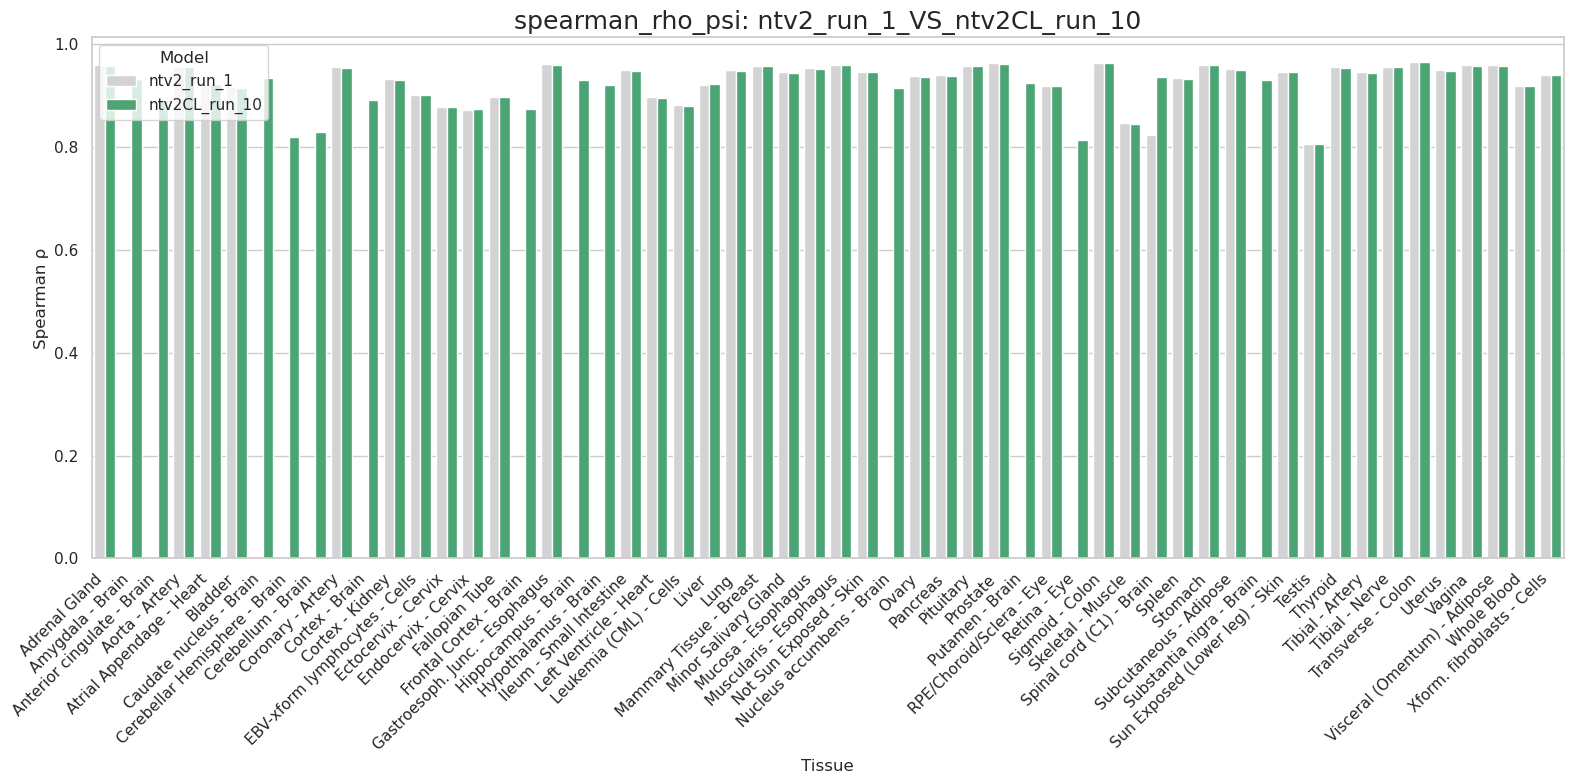

Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/spearman_rho_delta_psi_ntv2_run_1_VS_ntv2CL_run_10_2025_10_20__23_32_01.png


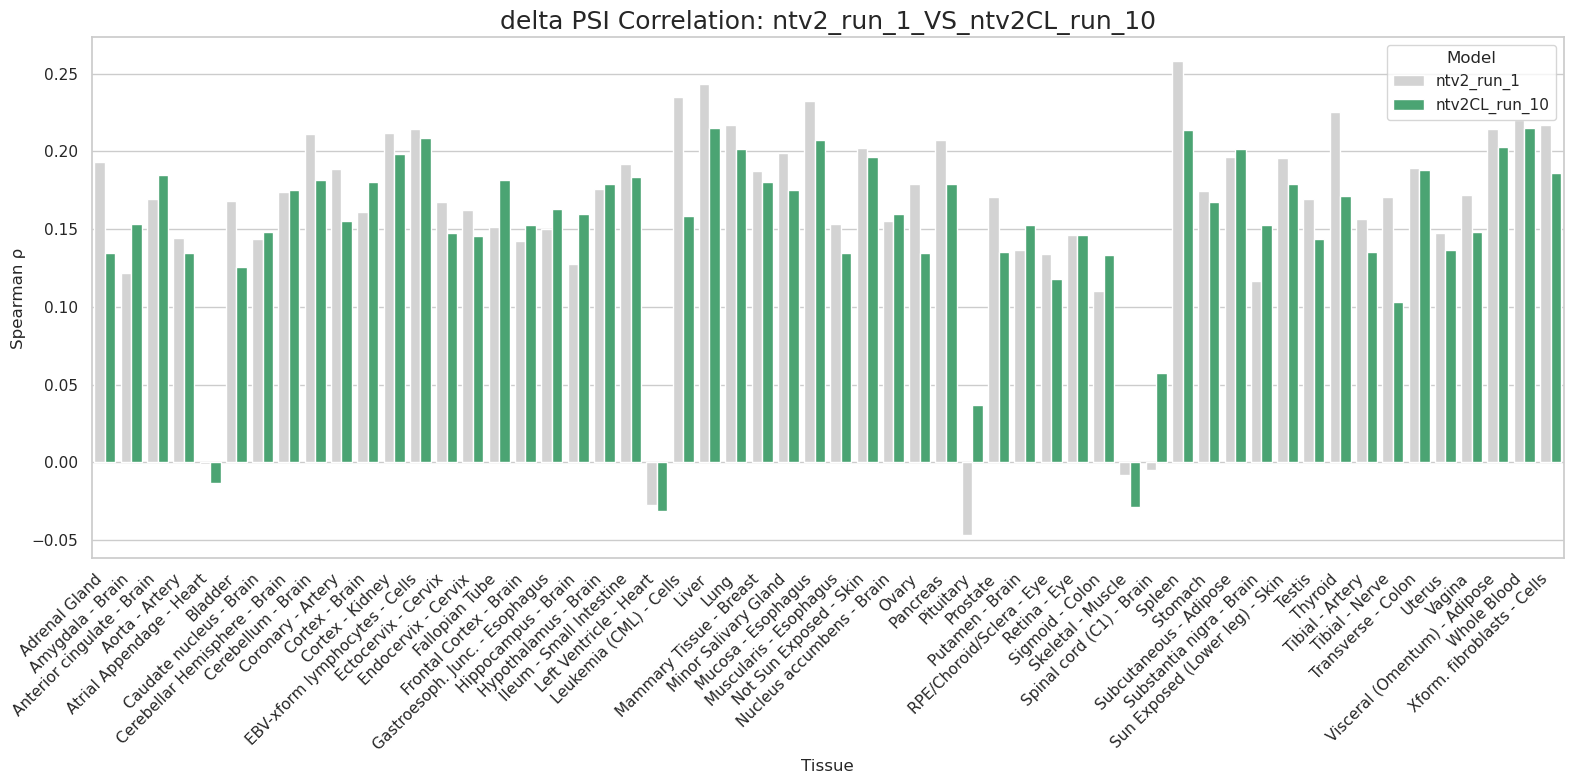

In [24]:
# Prepare the data
# Prepare the data SINGLE RUN 1 vs SINGLE RUN 2

model1_name = 'ntv2_run_1'
model2_name = 'ntv2CL_run_10'

# model1_name = 'MTSpliceOurTraining_run_23'
# model2_name = 'Resnet10augExonIntron_run_2'

# model1_name = 'MTSpliceOurTraining_run_23'
# model2_name = 'Resnet10augExonIntronWEIGHTED_run_28'

# model1_name = 'Resnet10augExonIntron_run_2'
# model2_name = 'Resnet10augExonIntronWEIGHTED_run_28'

title = f"{model1_name}_VS_{model2_name}"
import time
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")
fig_maindir = get_figures_path()

comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=single_run_1_results,
    df2=single_run_2_results,
    metric='spearman_rho_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'spearman_rho_psi: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_psi_{title}{trimester}.png"
)

# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=single_run_1_results,
    df2=single_run_2_results,
    metric='spearman_rho_delta_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'delta PSI Correlation: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_delta_psi_{title}{trimester}.png"
)





Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/spearman_rho_psi_ntv2_run_avg_VS_ntv2CL_run_avg_2025_10_20__23_33_22.png


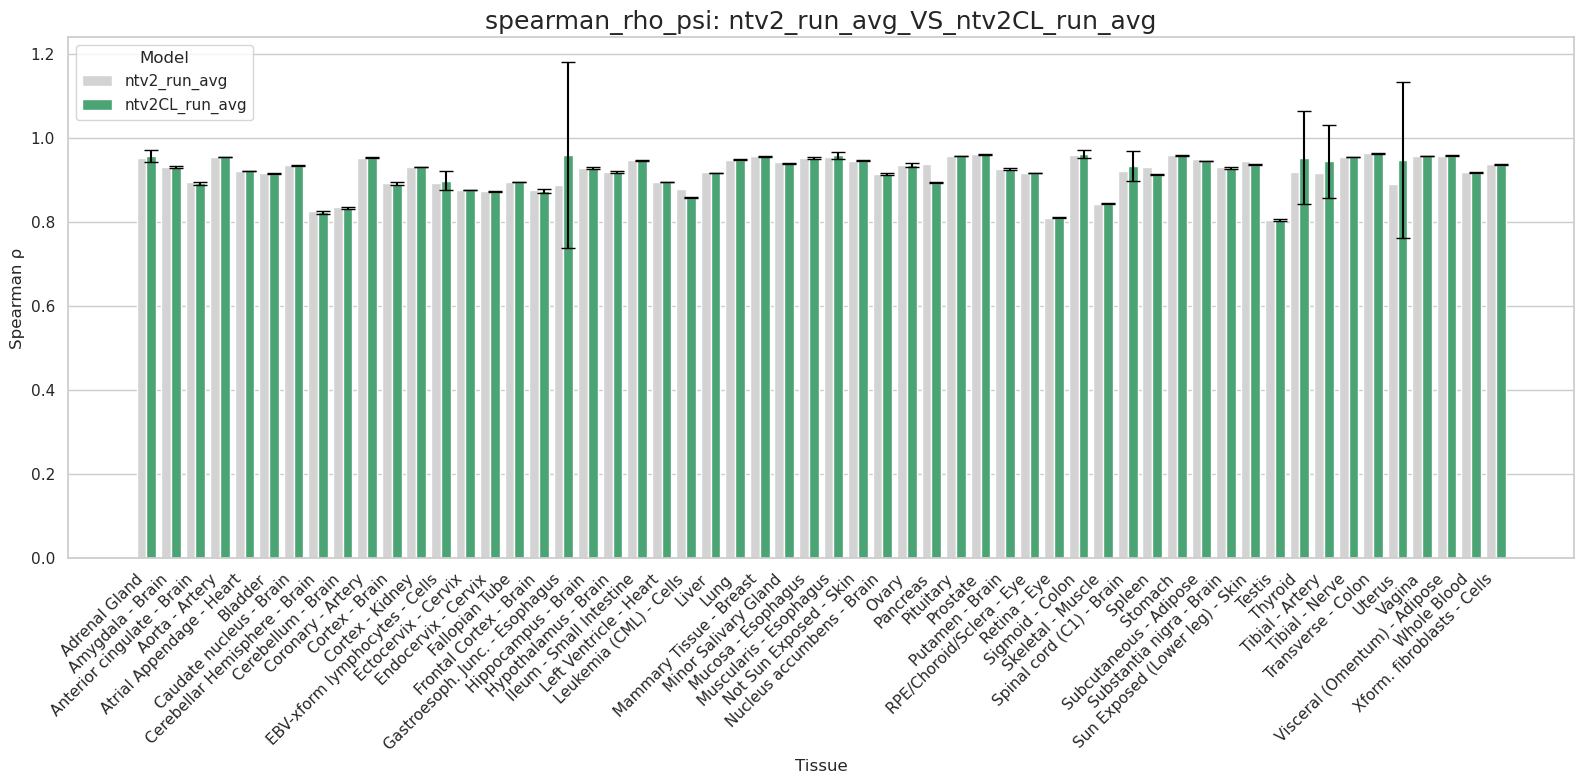

Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/spearman_rho_delta_psi_ntv2_run_avg_VS_ntv2CL_run_avg_2025_10_20__23_33_22.png


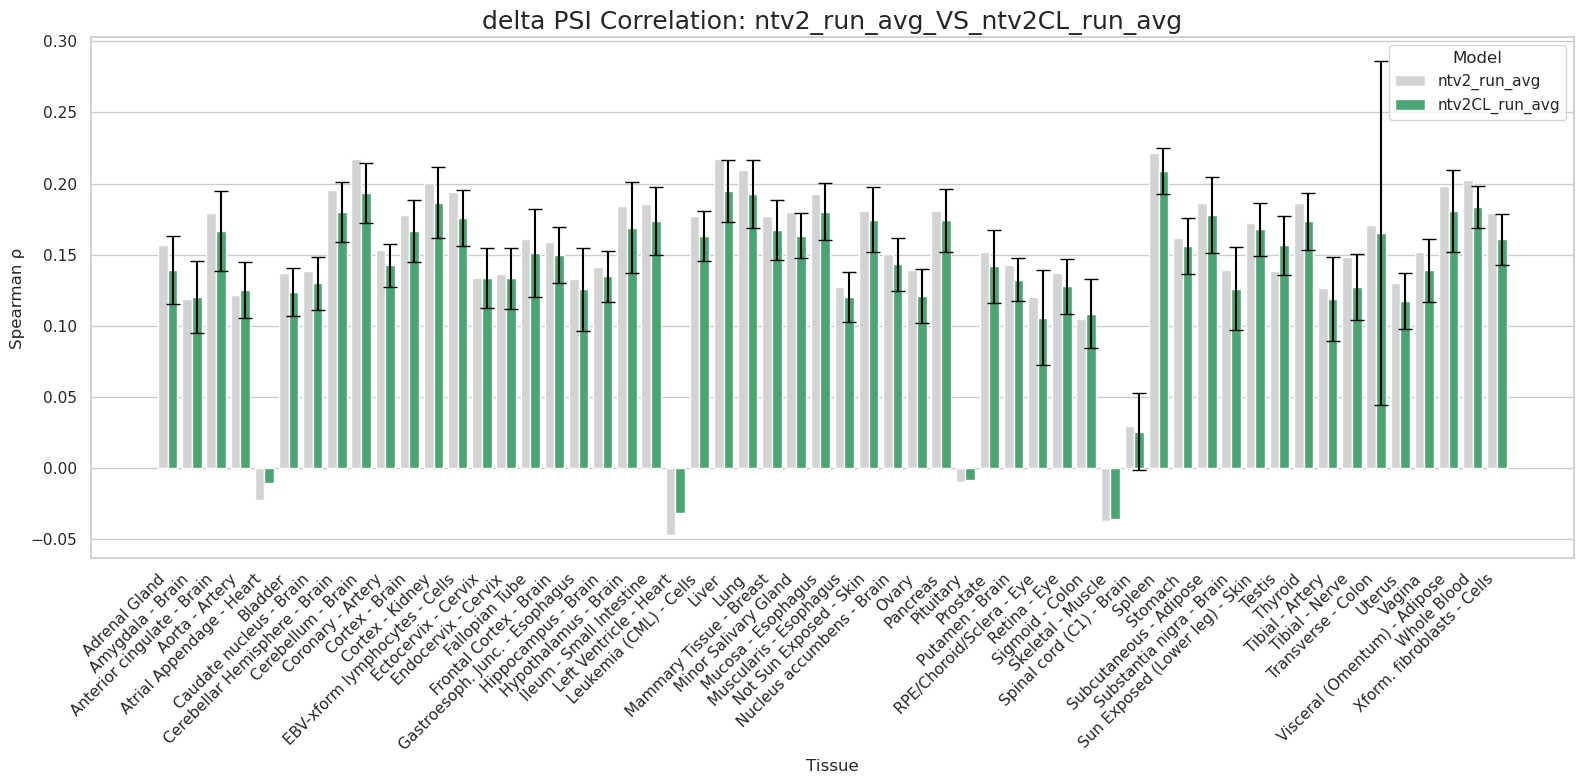

In [25]:
# Prepare the data

# Prepare the data average folder 1 vs SOTA
model1_name = 'ntv2_run_avg'
model2_name = 'ntv2CL_run_avg'

# model1_name = 'MTSpliceOurTraining_run_avg'
# model2_name = 'Resnet10augExonIntron_run_avg'

# model1_name = 'MTSpliceOurTraining_run_avg'
# model2_name = 'Resnet10augExonIntronWEIGHTED_run_avg'

# model1_name = 'Resnet10augExonIntron_run_avg'
# model2_name = 'Resnet10augExonIntronWEIGHTED_run_avg'

title = f"{model1_name}_VS_{model2_name}"
import time
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")
fig_maindir = get_figures_path()

comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=averaged_run_1_results,
    df2=averaged_run_2_results,
    metric='spearman_rho_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'spearman_rho_psi: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_psi_{title}{trimester}.png"
)

# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=averaged_run_1_results,
    df2=averaged_run_2_results,
    metric='spearman_rho_delta_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'delta PSI Correlation: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_delta_psi_{title}{trimester}.png"
)



In [ ]:
################ 2 user inputs ################
################ mtsplice original vs user input ################

In [ ]:
# 1. Load the SOTA data

# --- Please update these paths ---

# 1. Path to your State-of-the-Art (SOTA) results file.
#    This file should have at least 'tissue', 'spearman_rho_psi', 'spearman_rho_delta_psi' columns.
sota_file_name = "variable_all_tissues_spearman_correlations.tsv" # origianl mtsplice weighted model output
result_file_name = "exprmnt_2025_10_19__16_56_25" # ntv2

# main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/results/"
main_dir = "/mnt/home/at3836/Contrastive_Learning/files/results/"
SOTA_FILE_PATH = f"{main_dir}/mtsplice_originalTFweight_results/{sota_file_name}"

# 2. Path to the main folder containing all your experiment runs (e.g., run_1, run_2, etc.)
RESULTS_FOLDER_PATH = f"{main_dir}/{result_file_name}/weights/checkpoints"

# --- End of configuration ---

In [ ]:
# --- Assume these DataFrames are already loaded ---

# SOTA results
sota_results = load_sota_results(SOTA_FILE_PATH)

# Results for a single run
single_run_1_results = load_single_run_results(RESULTS_FOLDER_PATH, 'run_1')
print(single_run_1_results.head())

# Averaged results from one set of runs
averaged_run_1_results = load_and_average_all_runs(RESULTS_FOLDER_PATH)


In [ ]:
print(get_figures_path())

In [ ]:
# Prepare the data SINGLE RUN 1 vs SOTA
model1_name = 'MTSplice_original'
model2_name = 'ntv2_run_1'
title = f"{model1_name}_VS_{model2_name}"
import time
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")
fig_maindir = get_figures_path()

comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=single_run_1_results,
    metric='spearman_rho_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'spearman_rho_psi: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_psi_{title}{trimester}.png"
)

# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=single_run_1_results,
    metric='spearman_rho_delta_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'delta PSI Correlation: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_delta_psi_{title}{trimester}.png"
)

In [ ]:
# Prepare the data

# Prepare the data average folder 1 vs SOTA
model1_name = 'MTSplice_original'
model2_name = 'ntv2_average'

title = f"{model1_name}_VS_{model2_name}"
import time
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")
fig_maindir = get_figures_path()

comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=averaged_run_1_results,
    metric='spearman_rho_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'spearman_rho_psi: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_psi_{title}{trimester}.png"
)

# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=averaged_run_1_results,
    metric='spearman_rho_delta_psi',
    model1_name=model1_name,
    model2_name=model2_name
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title=f'delta PSI Correlation: {title}',
    model1_name=model1_name,
    model2_name=model2_name,
    save_path=f"{fig_maindir}/spearman_rho_delta_psi_{title}{trimester}.png"
)



In [ ]:
######################################